In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dropout, BatchNormalization, GaussianNoise
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import SGD

from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

import os
from os import listdir
from os.path import isfile, join
import time

import matplotlib.pyplot as plt
import numpy as np
import cv2

In [2]:
MonoModel = tf.saved_model.load('Mono_64_completo')

# Test with Test set

In [13]:
#fpath_Test = './MonoCristal/Argiak'
fpath_Test = './MonoCristal/Train-Val/Validation/Txarrak'

files_Test = [os.path.join(root, name)
            for root, dirs, files in os.walk(fpath_Test)
            for name in files
            if (name.endswith((".jpg", ".JPG")))and ('ROI' not in name)and ('heat' not in name)]

print(len(files_Test))

18


In [11]:
files_Test[15]

'./MonoCristal/Argiak/10070.jpg'

In [5]:
##Predict IMAGE & Save classified bmp
def Predictions(fname, tgt_folder,Models, new_w,new_h,overlap=0.5,mask=False):
    img_origin, images, img_shape = SlidingWindow(fname, new_w,new_h,overlap)
    images = tf.dtypes.cast(images, tf.float32)
    img_origin = np.asarray(img_origin)
    
    
    Predictions = []
    Masks = []
    Subws = []
        
    for i in range(len(Models)):
        print(images.shape)
        pred_y = Models[i](images)
                            
        if mask:
            img_mask = np.zeros(img_shape)
            img_subw = np.zeros(img_shape)
            for i in range(img_origin.shape[0]):
                w_rng = [img_origin[i,0],img_origin[i,0]+new_w]
                h_rng = [img_origin[i,1],img_origin[i,1]+new_h]
                # Next mask will tell how many times each pixes has been included for classification in a subwindow
                img_subw[w_rng[0]:w_rng[1], h_rng[0]:h_rng[1]] = img_subw[w_rng[0]:w_rng[1], h_rng[0]:h_rng[1]]+1
                if pred_y[i]<0.6:
                    img_mask[w_rng[0]:w_rng[1], h_rng[0]:h_rng[1]] = img_mask[w_rng[0]:w_rng[1], h_rng[0]:h_rng[1]]+(1-pred_y[i])

            #img_mask = img_mask*img_subw.max()/img_subw
            #img_mask = img_mask/img_subw
            #img_mask[img_mask<0.65]=0
        else:
            img_mask = []
            img_subw = []
            
        Predictions.append(pred_y)
        Masks.append(img_mask)
        Subws.append(img_subw)
            

    
    return Predictions, images, img_origin, Masks, Subws


def SlidingWindow(fname, new_w,new_h,overlap=0.5):
    img = cv2.imread(fname,0)
    #img = cv2.resize(img, (0,0), fx=0.5, fy=0.5)#For monocristal cells to mantain proportions
    #img = cv2.GaussianBlur(img,(5,5),0)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img = clahe.apply(img)
    #img = cv2.equalizeHist(img)
    #Rescale Image
    img = img*1./255
    
    img_w = img.shape[0]
    img_h = img.shape[1]
    
    images = []
    img_origin = []
    w_len = 0
    for i,vali in enumerate(range(0,img_w,int(new_w - overlap*new_w))):
        h_len = 0
        if w_len != 1: #NO estamos en la esquina de la figura
            for j,valj in enumerate(range(0,img_h,int(new_h - overlap*new_h))):
                if h_len != 1: # NO estamos en la esquina de la figura
                    #take img
                    w_rng = [vali, vali+new_w]
                    h_rng = [valj, valj+new_h]
                    if (vali+new_w > img_w):
                        w_len=1 #estamos en la esquina de la figura
                        w_rng = [img_w-new_w, img_w]
                    if (valj+new_h > img_h):
                        h_len=1    
                        h_rng = [img_h-new_h, img_h]
                    
                    new_img = img[w_rng[0]:w_rng[1], h_rng[0]:h_rng[1]]
                    new_img = img_to_array(new_img)
                    
                    #print(new_img)
                    images.append(new_img)                    
                    img_origin.append([w_rng[0], h_rng[0]])
                        
    images = np.asarray(images)
    #tf.dtypes.cast(img1, tf.float32)
    #images.append((img*1./255).reshape(img.shape[0],img.shape[1],1))
    #images = tf.dtypes.cast(images, tf.float32)
    #print(images.shape)
    img_origin = np.asarray(img_origin)
    return img_origin, images, img.shape

In [7]:
fname=files_Test[15]
img_w = 64
img_h = 64
Models = []
Models.append(MonoModel)

predictions, images, img_origin, masks, subws = Predictions(fname, '.',Models,img_w,img_h,mask=True)

(676, 64, 64, 1)


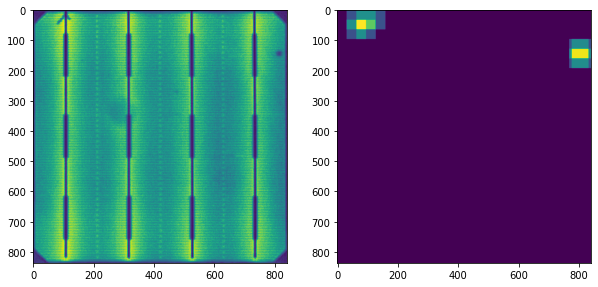

In [8]:
img = cv2.imread(fname,0)
#img = cv2.resize(img, (0,0), fx=0.5, fy=0.5)#For monocristal cells to mantain proportions
#img = cv2.GaussianBlur(img,(5,5),0)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
img = clahe.apply(img)
#img = cv2.equalizeHist(img)
#Rescale Image
img = img*1./255

plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(masks[0])
plt.show()

./MonoCristal/Train-Val/Validation/Txarrak/1055.jpg
(2500, 64, 64, 1)


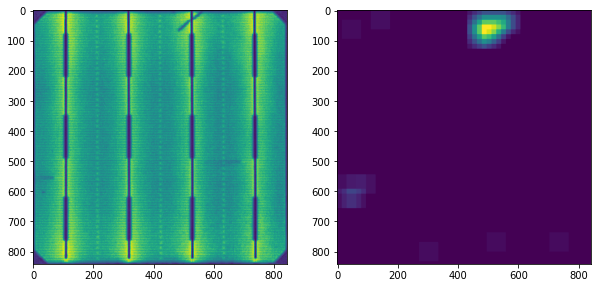

./MonoCristal/Train-Val/Validation/Txarrak/1075.jpg
(2500, 64, 64, 1)


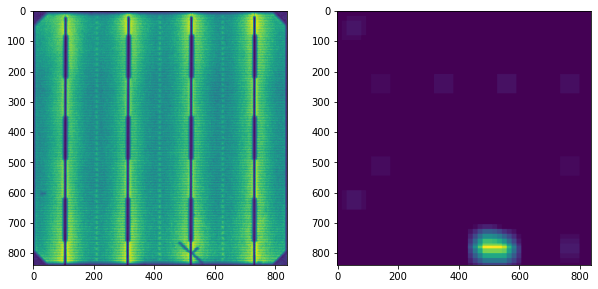

./MonoCristal/Train-Val/Validation/Txarrak/1007.jpg
(2500, 64, 64, 1)


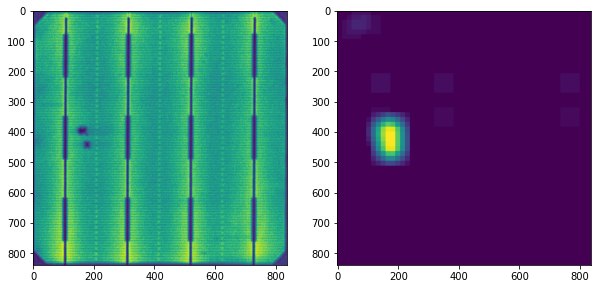

./MonoCristal/Train-Val/Validation/Txarrak/1087.jpg
(2500, 64, 64, 1)


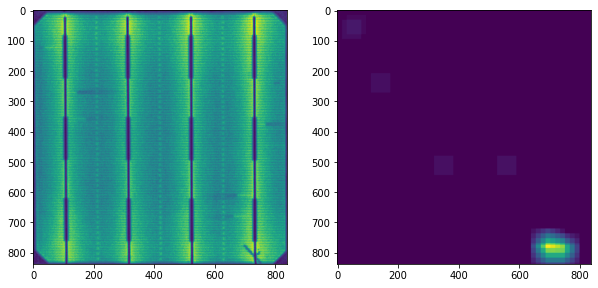

./MonoCristal/Train-Val/Validation/Txarrak/1200.jpg
(2500, 64, 64, 1)


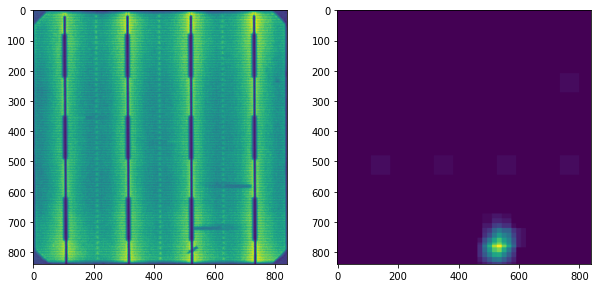

./MonoCristal/Train-Val/Validation/Txarrak/1049.jpg
(2500, 64, 64, 1)


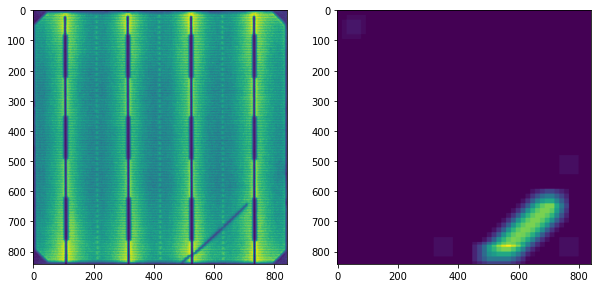

./MonoCristal/Train-Val/Validation/Txarrak/1106.jpg
(2500, 64, 64, 1)


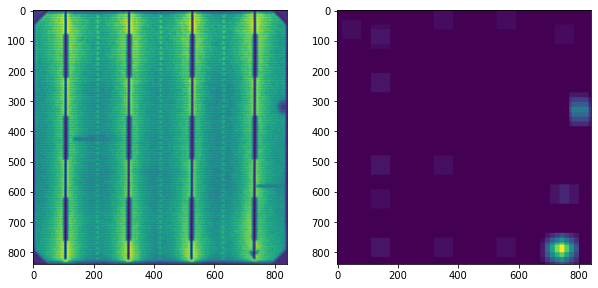

./MonoCristal/Train-Val/Validation/Txarrak/1030.jpg
(2500, 64, 64, 1)


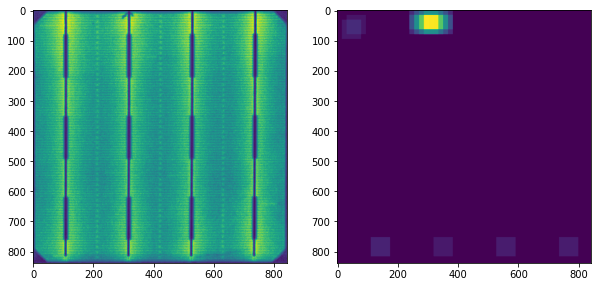

./MonoCristal/Train-Val/Validation/Txarrak/1066.jpg
(2500, 64, 64, 1)


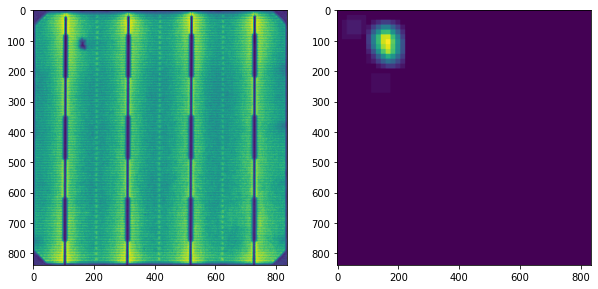

./MonoCristal/Train-Val/Validation/Txarrak/1118.jpg
(2500, 64, 64, 1)


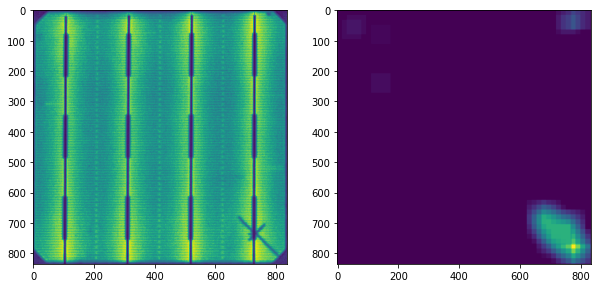

./MonoCristal/Train-Val/Validation/Txarrak/1184.jpg
(2500, 64, 64, 1)


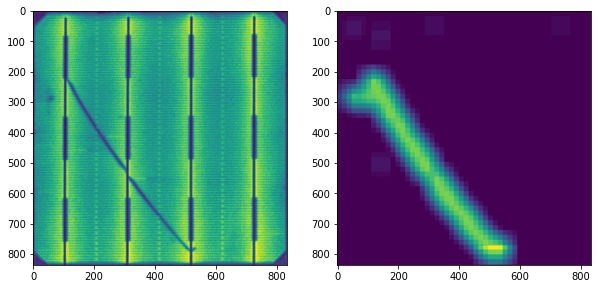

./MonoCristal/Train-Val/Validation/Txarrak/1151.jpg
(2500, 64, 64, 1)


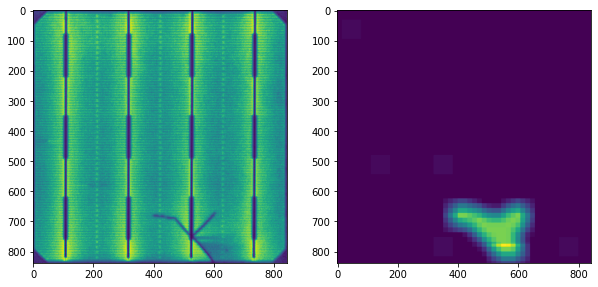

./MonoCristal/Train-Val/Validation/Txarrak/1080.jpg
(2500, 64, 64, 1)


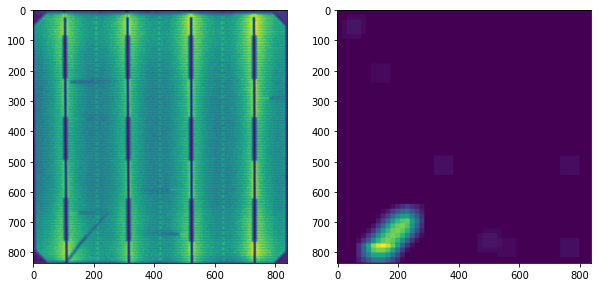

./MonoCristal/Train-Val/Validation/Txarrak/1048.jpg
(2500, 64, 64, 1)


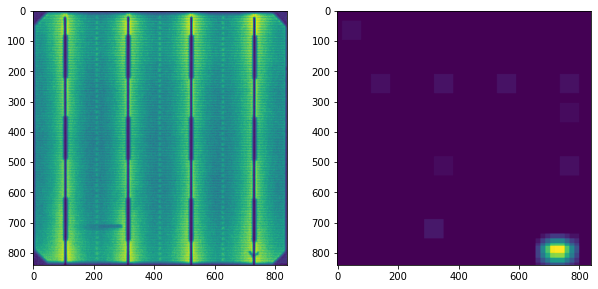

./MonoCristal/Train-Val/Validation/Txarrak/1161.jpg
(2500, 64, 64, 1)


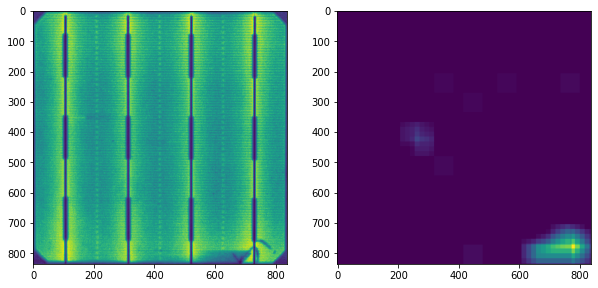

./MonoCristal/Train-Val/Validation/Txarrak/1194.jpg
(2500, 64, 64, 1)


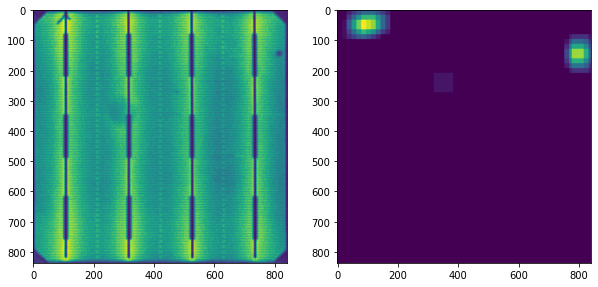

./MonoCristal/Train-Val/Validation/Txarrak/1022.jpg
(2500, 64, 64, 1)


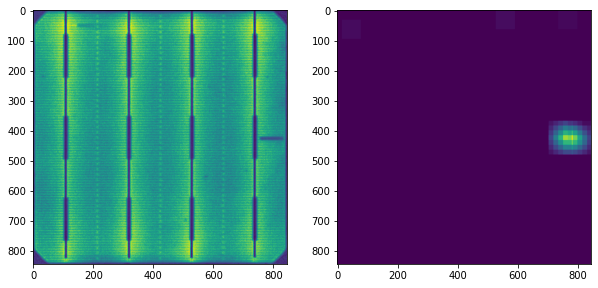

./MonoCristal/Train-Val/Validation/Txarrak/1191.jpg
(2500, 64, 64, 1)


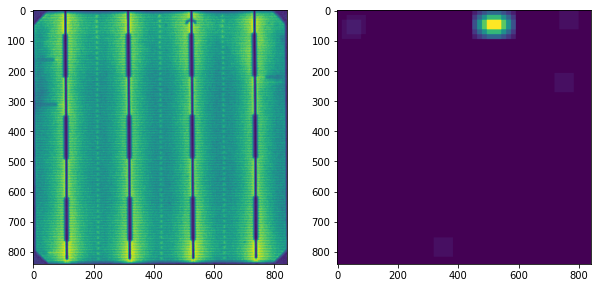

In [14]:
img_w = 64
img_h = 64
Models = []
Models.append(MonoModel)

for fname in files_Test:
    print(fname)
    predictions, images, img_origin, masks, subws = Predictions(fname, '.',Models,img_w,img_h,overlap=0.75,mask=True)
    
    img = cv2.imread(fname,0)
    #img = cv2.resize(img, (0,0), fx=0.5, fy=0.5)#For monocristal cells to mantain proportions
    #img = cv2.GaussianBlur(img,(5,5),0)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img = clahe.apply(img)
    #img = cv2.equalizeHist(img)
    #Rescale Image
    img = img*1./255

    plt.figure(figsize=(10,10))
    plt.subplot(121)
    plt.imshow(img)
    plt.subplot(122)
    plt.imshow(masks[0])
    plt.show()


# Test with Train && Validation data

In [34]:

pth_Train = './data_poli/train'
files_Train = [os.path.join(root, name)
            for root, dirs, files in os.walk(pth_Train)
            for name in files
            if (name.endswith((".bmp", ".BMP")))and ('ROI' not in name)and ('heat' not in name)]

pth_Validation = './data_poli/validation'
files_Val = [os.path.join(root, name)
            for root, dirs, files in os.walk(pth_Validation)
            for name in files
            if (name.endswith((".bmp", ".BMP")))and ('ROI' not in name)and ('heat' not in name)]
print(len(files_Train),len(files_Val))


54447 5739


In [35]:
st = 10000
for i in range(10):
    print(i, files_Train[st+i])
    #print(i, files_Val[st+i])

0 ./data_poli/train/bad/B_1110_15_7_180.bmp
1 ./data_poli/train/bad/B_1104_20_17.bmp
2 ./data_poli/train/bad/B_1104_0_14_270.bmp
3 ./data_poli/train/bad/B_1133_2_6.bmp
4 ./data_poli/train/bad/B_1059_20_29_180.bmp
5 ./data_poli/train/bad/B_1101_36_37_270.bmp
6 ./data_poli/train/bad/B_1055_0_24_180.bmp
7 ./data_poli/train/bad/B_1110_26_13.bmp
8 ./data_poli/train/bad/B_1132_10_24_180.bmp
9 ./data_poli/train/bad/B_1125_33_5_270.bmp


In [131]:
PoliModel = tf.saved_model.load('Poli_64_grande')


In [40]:
images = []
st = 900
for i in range(10):
    fname = files_Val[st+i]
    print(i, fname)
    
    img = cv2.imread(fname,0)
    img = np.float32(img*1./255)
    images.append(img)
    #plt.imshow(img)
    #plt.show()

images = np.asarray(images)
print(images.shape)
images = images.reshape(images.shape[0],images.shape[1],images.shape[2],1)
print(images.shape)

pred_y = PoliModel(images)
pred_y.numpy

0 ./data_poli/validation/bad/B_1053_10_12_90.bmp
1 ./data_poli/validation/bad/B_1103_38_23.bmp
2 ./data_poli/validation/bad/B_1003_31_37.bmp
3 ./data_poli/validation/bad/B_1105_24_5_90.bmp
4 ./data_poli/validation/bad/B_1123_23_6_90.bmp
5 ./data_poli/validation/bad/B_1124_21_30_180.bmp
6 ./data_poli/validation/bad/B_1102_10_10_180.bmp
7 ./data_poli/validation/bad/B_1064_31_2_90.bmp
8 ./data_poli/validation/bad/B_1125_37_5.bmp
9 ./data_poli/validation/bad/B_1150_20_16.bmp
(10, 64, 64)
(10, 64, 64, 1)


<bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(10, 1), dtype=float32, numpy=
array([[5.9102601e-01],
       [2.0948727e-02],
       [7.8221518e-01],
       [2.4058747e-03],
       [1.2007741e-01],
       [1.0166603e-12],
       [7.8141954e-07],
       [4.1010804e-05],
       [6.7045045e-01],
       [3.5504812e-01]], dtype=float32)>>

0 ./data_poli/validation/bad/B_1053_10_12_90.bmp


/usr/local/lib/python3.8/dist-packages/matplotlib/text.py:1215: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


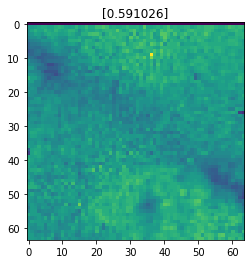

1 ./data_poli/validation/bad/B_1103_38_23.bmp


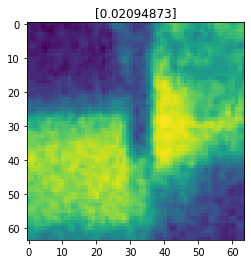

2 ./data_poli/validation/bad/B_1003_31_37.bmp


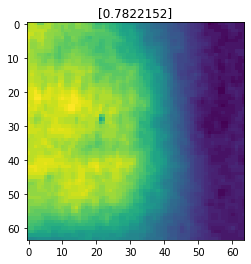

3 ./data_poli/validation/bad/B_1105_24_5_90.bmp


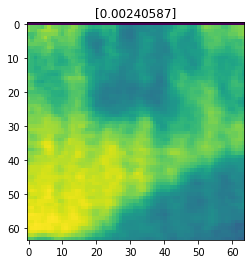

4 ./data_poli/validation/bad/B_1123_23_6_90.bmp


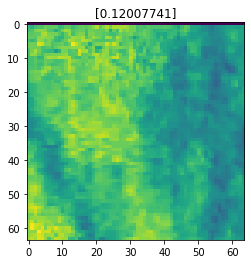

5 ./data_poli/validation/bad/B_1124_21_30_180.bmp


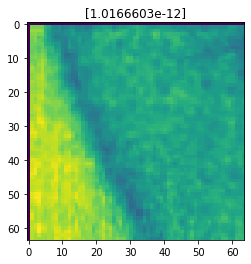

6 ./data_poli/validation/bad/B_1102_10_10_180.bmp


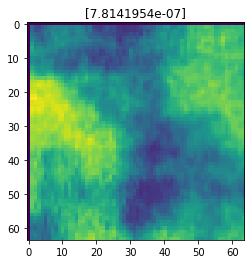

7 ./data_poli/validation/bad/B_1064_31_2_90.bmp


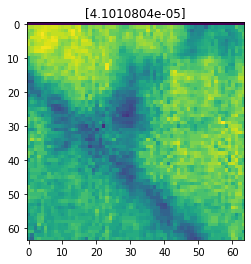

8 ./data_poli/validation/bad/B_1125_37_5.bmp


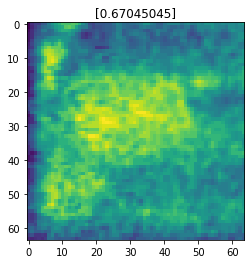

9 ./data_poli/validation/bad/B_1150_20_16.bmp


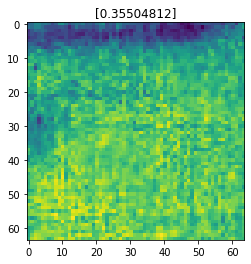

In [43]:
for i in range(10):
    fname = files_Val[st+i]
    print(i, fname)
    
    img = cv2.imread(fname,0)
    img = np.float32(img*1./255)    
    plt.imshow(img)
    plt.title(np.array(pred_y)[i])
    plt.show()